# LANL Earthquake Prediction

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy
import scipy.signal as signal
import dask.dataframe as dd
import dask.array as da
import pandas as pd
pd.options.display.precision = 25
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc
gc.enable()
from tqdm import tqdm
import pickle

## 1. Buisness Problem description

### 1.1 Data
Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

In this competition, you will address when the earthquake will take place. Specifically, you’ll predict the time remaining before laboratory earthquakes occur from real-time seismic data.

Here, we are given the 'acoustic data' which is used to predict the time remaining before the nex earthquake. The train data is a single, continuous segment of data. The test data consists of small segments for which we have to predict the time remaining after the next earthquake.

### 1.2 Metrics
The metric for evaluation is given as Mean Absolute Error(MAE), which is defined as,
\begin{equation*}
MAE = \frac{1}{n} \sum_{i=1}^{n}| (\hat y_i - y_i) |
\end{equation*}
where,
${\hat y_i}$ is the predicted value and ${y_i}$ is the true value.

# EDA

In [2]:
# we are reading the csv file using dask dataframe.
df = dd.read_csv('train.csv',dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float64},blocksize='10MB')
df

,acoustic_data,time_to_failure
npartitions=956,,
,int16,float64
,...,...
...,...,...
,...,...
,...,...


In [3]:
df.npartitions

956

In [4]:
df['acoustic_data'].max().compute()

5444

In [5]:
df['acoustic_data'].min().compute()

-5515

In [6]:
df.head(20)

,acoustic_data,time_to_failure
0,12,1.4690999832000000147047558
1,6,1.4690999821000001457349526
2,8,1.4690999809999998326759396
3,5,1.4690999799000001857507414
4,8,1.4690999787999998726917283
5,8,1.4690999777000000037219252
6,9,1.4690999765999999127075171
7,7,1.4690999755000000437377139
8,-5,1.4690999743999999527233058
9,3,1.4690999733000000837535026


In [7]:
df.describe().compute()

,acoustic_data,time_to_failure
count,6.2914548000000000000000000e+08,6.2914548000000000000000000e+08
mean,4.5194675737001244186785698e+00,5.6782917129788739174500733e+00
std,6.1633644994667244887409652e+00,3.6726965194435732264821581e+00
min,-5.5150000000000000000000000e+03,9.5503963166000010488743133e-05
25%,3.0000000000000000000000000e+00,3.5268977307500000151208042e+00
50%,5.0000000000000000000000000e+00,7.1700971291749997504894054e+00
75%,8.0000000000000000000000000e+00,1.6068095950250000925052518e+01
max,5.4440000000000000000000000e+03,1.6107399999999998385646904e+01


In [8]:
len(df)

629145480

For train data, we are provided with a continuous time-series data with more than 629 million data points. The 'acoustic data' which is the instrument reading is encoded in 16-bit integer. The 'time_to_failure' is the time in seconds before occurence of an earthquake.

In [9]:
files = os.listdir('test/')
print(len(files))

2624


In [10]:
test = pd.read_csv('test/'+files[0],dtype = {'acoustic_data': np.int16})
print(test.shape)

(150000, 1)


In [11]:
test.head(20)

,acoustic_data
0,4
1,0
2,-2
3,0
4,2
5,-3
6,-9
7,-4
8,11
9,11


In [12]:
test.dtypes

acoustic_data    int16
dtype: object

For test data, there are 2624 csv files, each having 150,000 datapoints. For each of the files, we have to predict 'time_to_failure' after the data has been seen.

In [13]:
del test

In [3]:
acoustic_data = np.array(df['acoustic_data'].compute(),dtype=np.int16)
time_to_failure = df['time_to_failure'].to_dask_array(lengths=True)

In [4]:
time_to_failure

dask.array<array, shape=(629145480,), dtype=float64, chunksize=(667802,)>

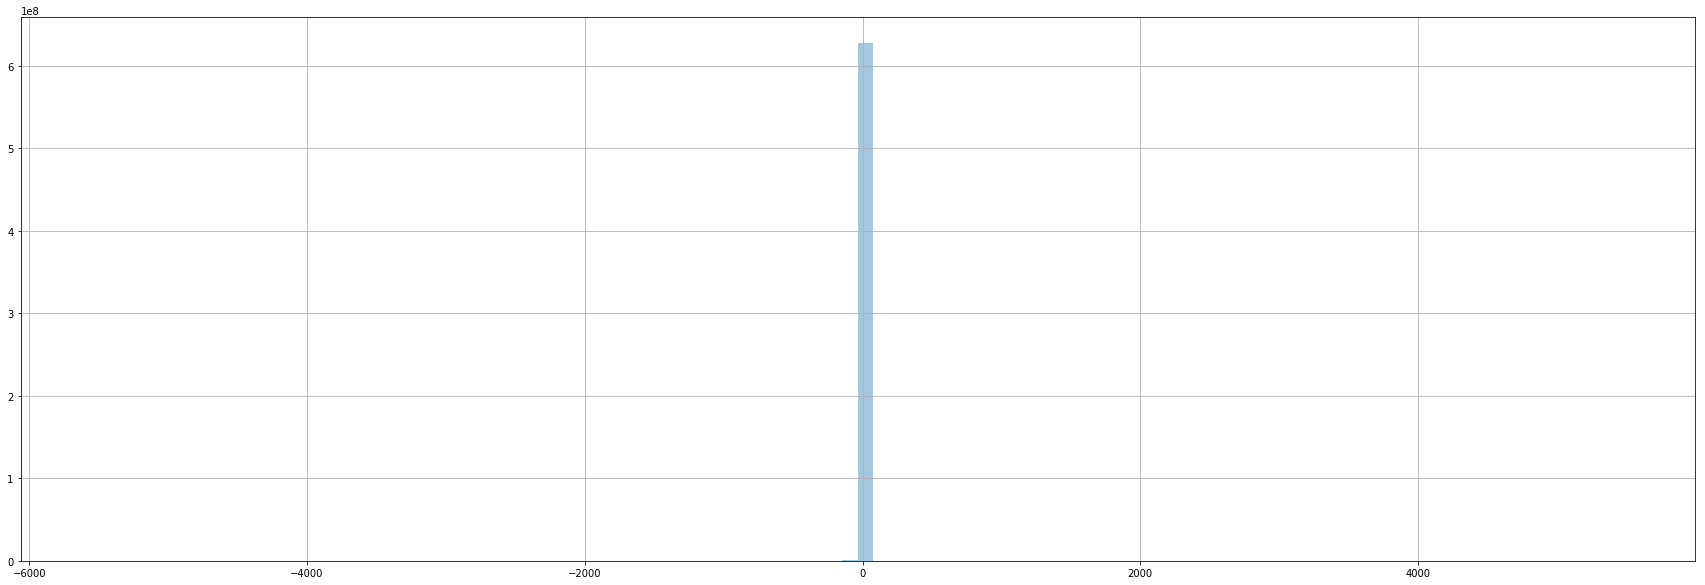

In [34]:
plt.figure(figsize=(30,10))
sns.distplot(acoustic_data,kde=False,bins=100)
plt.grid()
plt.show()

[]

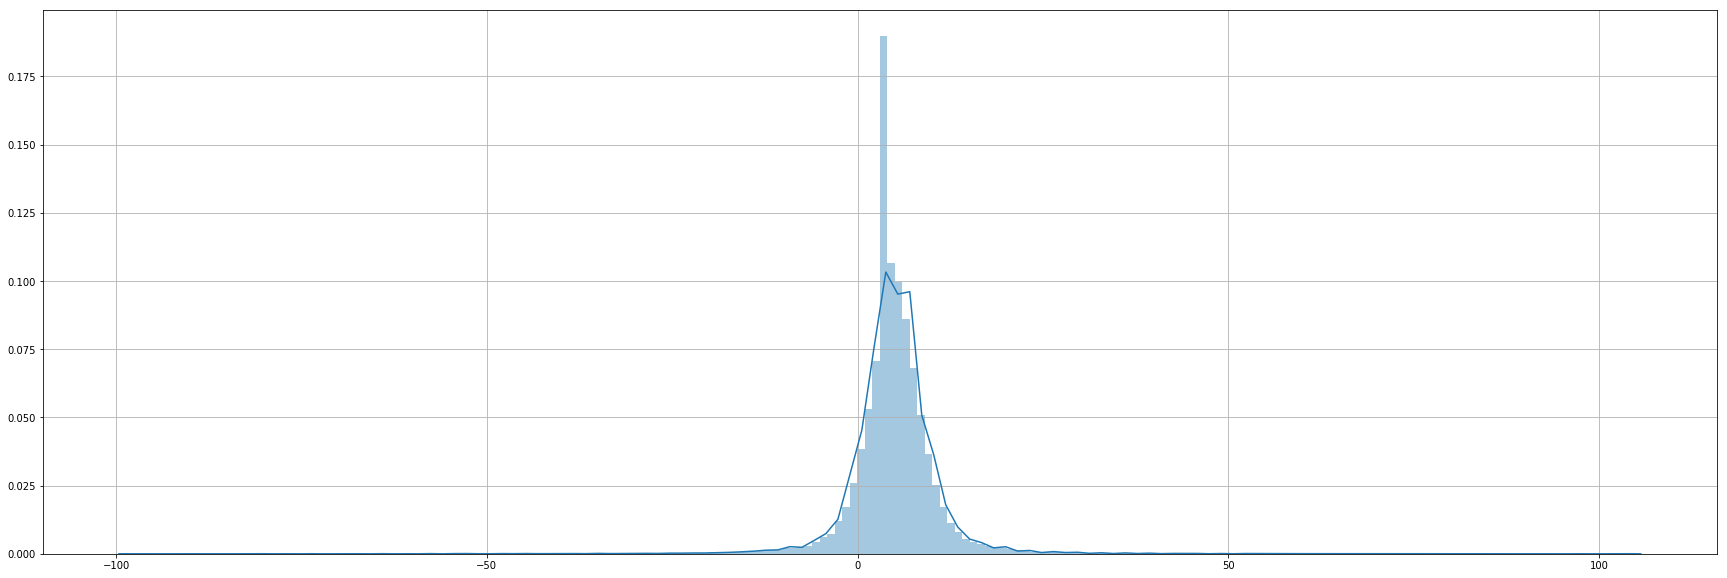

In [33]:
plt.figure(figsize=(30,10))
sns.distplot(acoustic_data[:50000],kde=True,bins=200)
plt.grid()
plt.plot()

If we plot the whole acoustic_data, we can see that almost all the data is on the positive side of value 0. The first 50000 rows of the acoustic data shows almost a gaussian distribution with mean > 0.

[]

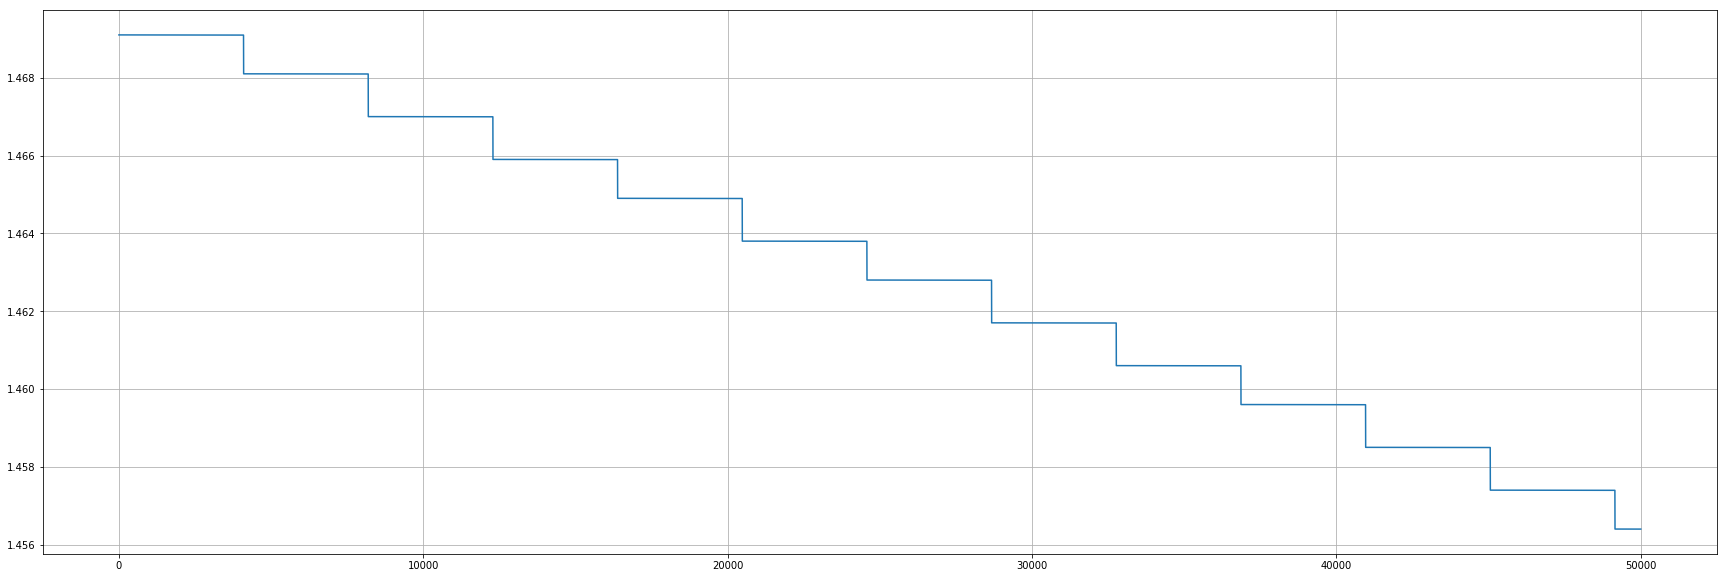

In [37]:
plt.figure(figsize=(30,10))
plt.plot(time_to_failure[:50000])
plt.grid()
plt.plot()

The first 50000 values of 'time_to_failure' indicates the step-like decrement of data.But this zoomed in graph does not give us any other relevent data. Hence we plot 2% of the whole data which is sampled at regular intervals.

<Figure size 2160x1440 with 0 Axes>

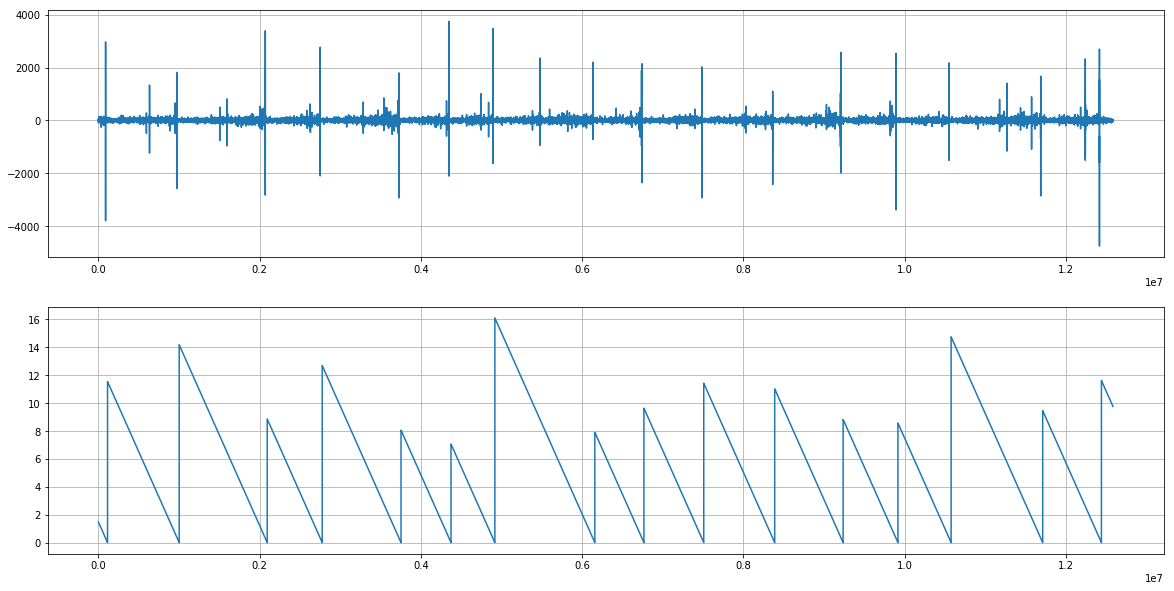

In [16]:
# sampling every 50th datapoint from both 'acoustic_data' and 'time_to_failure'
plt.figure(figsize=(30,20))
fig, axs = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
axs[0].grid()
axs[1].grid()
axs[0].plot(range(629145480//50 + 1), acoustic_data[::50])
axs[1].plot(range(629145480//50 + 1), time_to_failure[::50].compute())
plt.show()

We can see that, the earthquakes seem happen when the 'time_to_failure' reaches almost 0. In this 2% of the data sampled, we have 16 earthquakes. But we can see that the 'acoustic data' has about 20 peaks which might indicate an earthquake. But we should zoom on in the data where 'time_to_failure' reached zero.

<Figure size 2160x1440 with 0 Axes>

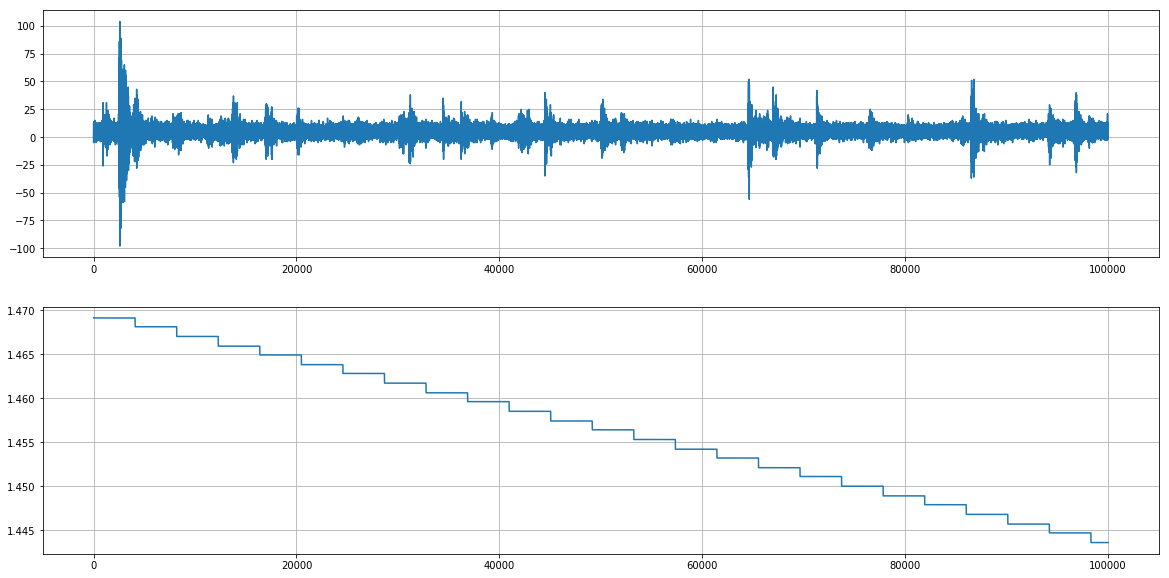

In [43]:
# sampling first 100000 datapoints
plt.figure(figsize=(30,20))
fig, axs = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
axs[0].grid()
axs[1].grid()
axs[0].plot(range(100000), acoustic_data[:100000])
axs[1].plot(range(100000), time_to_failure[:100000].compute())
plt.show()

<Figure size 2160x1440 with 0 Axes>

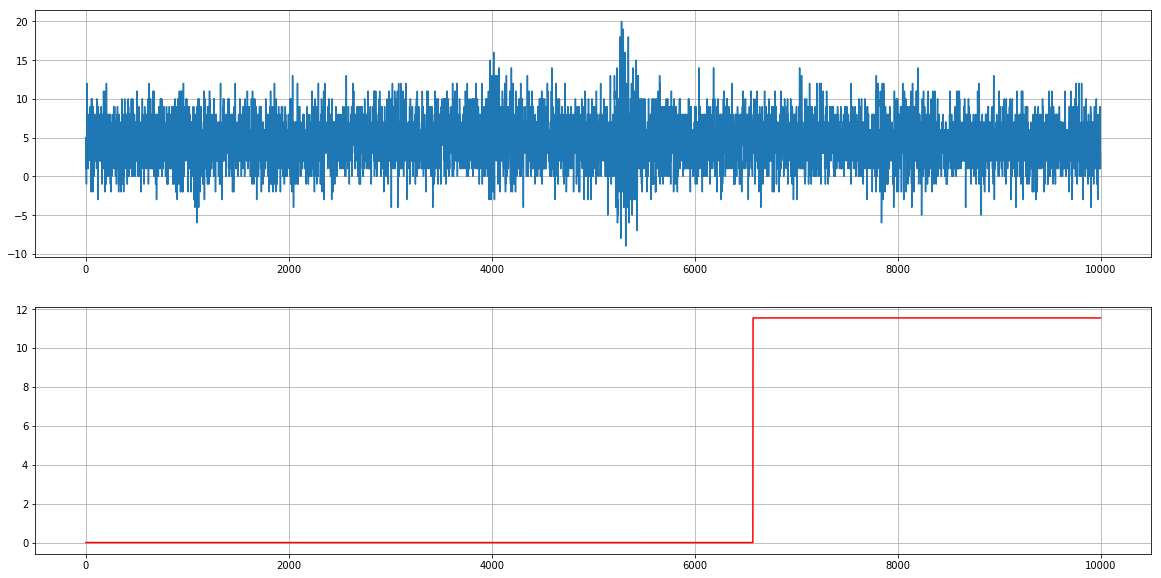

In [64]:
# sampling every 50th datapoint from both 'acoustic_data' and 'time_to_failure'
plt.figure(figsize=(30,20))
fig, axs = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
axs[0].grid()
axs[1].grid()
axs[0].plot(range(10000), acoustic_data[5650000:5660000])
axs[1].plot(range(10000), time_to_failure[5650000:5660000].compute(),'r')
plt.show()

## Summary
- 'time_to_failure' is represented as 64-bit float values and 'acoustic_data' is repesented as 16-bit unsigned int values.
- There are no nan values in the given dataset.
- For acoustic data, the minimum is -5515, the maximum is 5444 and the mean value is 4.52.
- For 'time_to_failure' data, the minimum is 9.55e-5 seconds, the maximum is 16.1 seconds and the mean value is 5.68 seconds.
- We can see that plotting the whole acoustic data does not give much information, but zooming on certain parts for the data reveals an almost Gaussian distribution.
- In the last plot, we can see that there are lot of oscilations between the peak oscilations and when the 'time_to_failure' reaches 0.

# Utility functions

In [2]:
#data sharpening
""" via Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening by Heeryon Choand Sang Min Yoon"""
from scipy.ndimage import gaussian_filter1d
def sharpen(series,sigma,alpha):
    denoised = gaussian_filter1d(series,sigma)
    detailed = series - denoised
    sharpened = series + alpha*detailed
    return sharpened

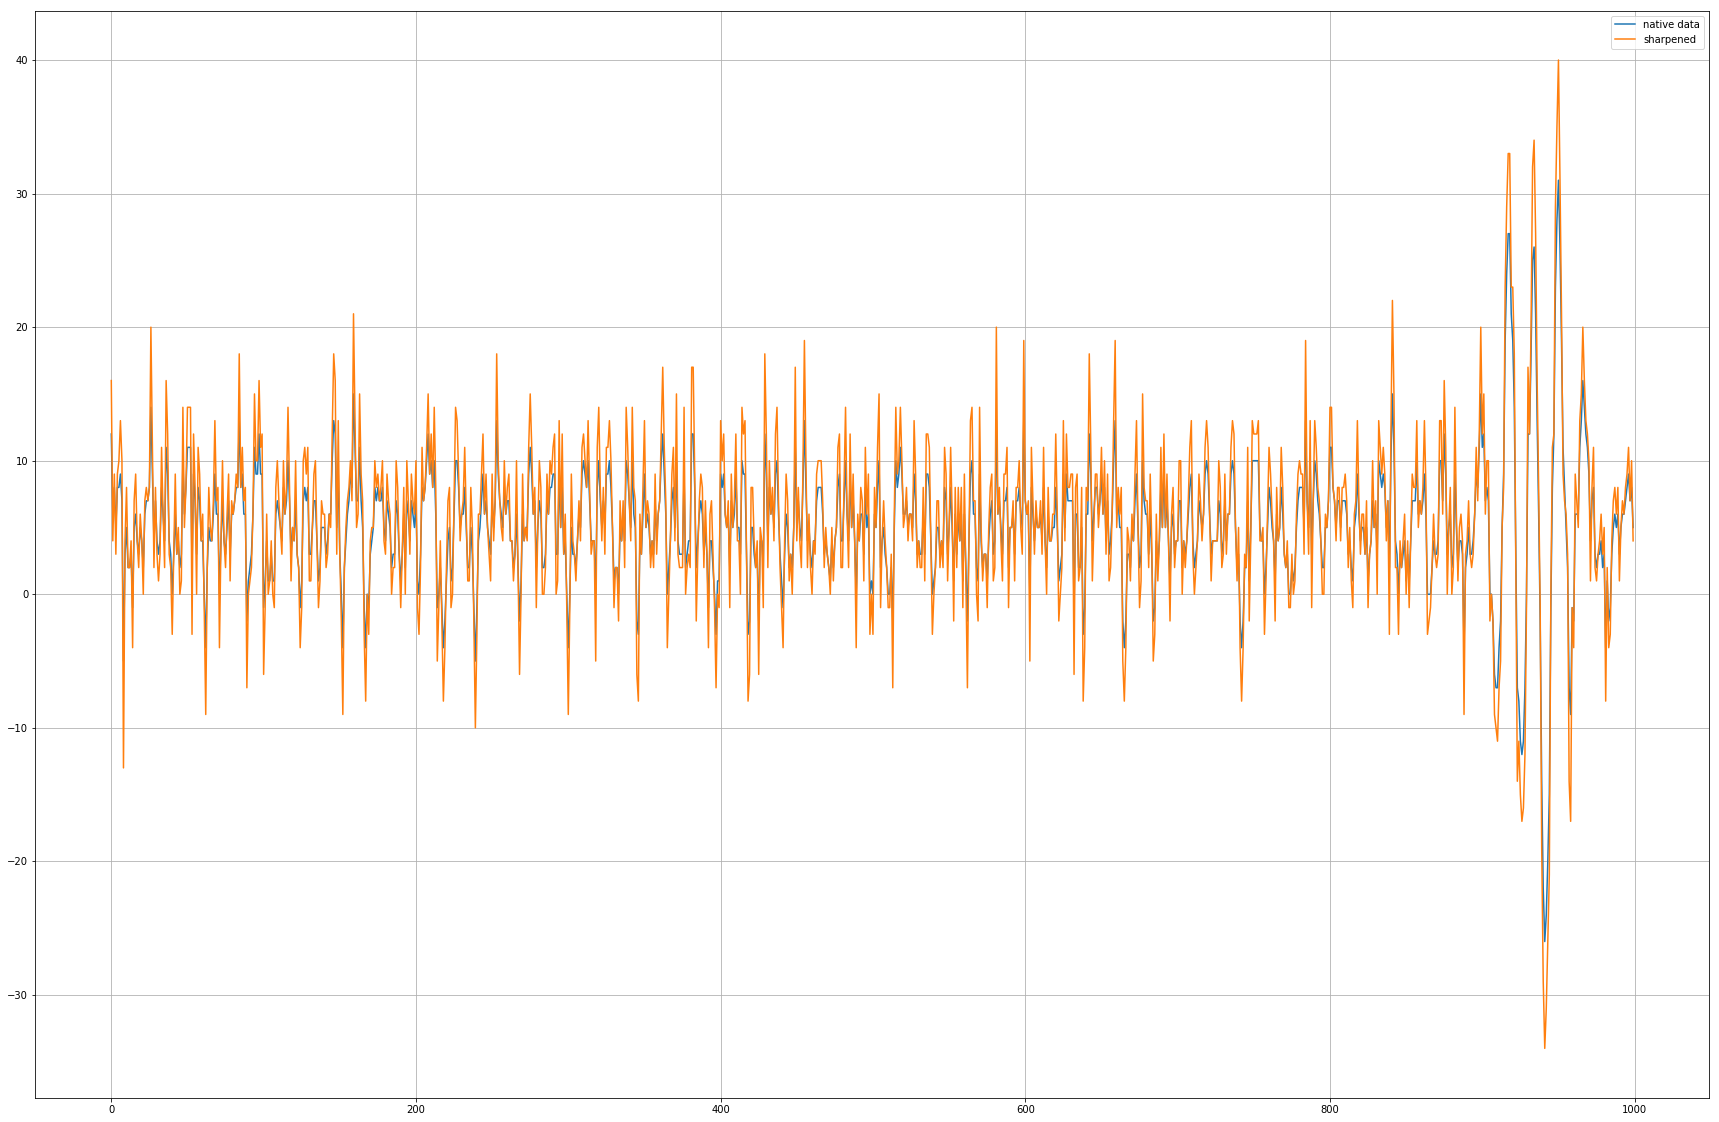

In [42]:
# visualization of how sharpened data looks like.
sharpened = sharpen(acoustic_data[:1000],2,1)
plt.figure(figsize=(30,20))
plt.plot(range(1000),acoustic_data[:1000],label='native data')
plt.plot(range(1000),sharpened,label='sharpened')
plt.legend()
plt.grid()
plt.show()

The 'data sharpening' process enhances the contrast between the peaks. As we can see above, the peaks are enhanced and differentiated from the non-peaks. This actually helps us with detecting even the faintest signals.

In [3]:
def simple_statistical_features(segment):
    """ This function extracts simple statistical features"""
    result = []
    # different means
    result.append(np.mean(segment)) #simple mean
    result.append(np.mean(segment[:10000])) #first 10000 observation's mean
    result.append(np.mean(segment[:50000])) # first 50000 observation's mean
    result.append(np.mean(segment[-10000:])) # last 10000 observation's mean
    result.append(np.mean(segment[-50000:])) # last 50000 observation's mean
    # different standard deviation
    result.append(np.std(segment))#simple std
    result.append(np.std(segment[:10000])) #first 10000 observation's std
    result.append(np.std(segment[:50000]))# first 50000 observation's std
    result.append(np.std(segment[-10000:])) # last 10000 observation's std
    result.append(np.std(segment[-50000:])) # last 50000 observation's std
    # different maximum
    result.append(np.max(segment)) #simple maximum
    result.append(np.max(segment[:10000])) #first 10000 observation's maximum
    result.append(np.max(segment[:50000])) # first 50000 observation's maximum
    result.append(np.max(segment[-10000:])) # last 10000 observation's maximum
    result.append(np.max(segment[-50000:])) # last 50000 observation's maximum
    # different minimum
    result.append(np.min(segment)) #simple minimum
    result.append(np.min(segment[:10000])) #first 10000 observation's minimum
    result.append(np.min(segment[:50000]))# first 50000 observation's minimum
    result.append(np.min(segment[-10000:])) # last 10000 observation's minimum
    result.append(np.min(segment[-50000:])) # last 50000 observation's minimum
    # different percentiles
    result.append(np.percentile(segment,5)) # 5th percentile
    result.append(np.percentile(segment,25)) # 25th percentile
    result.append(np.percentile(segment,50)) # 50th percentile
    result.append(np.percentile(segment,75)) # 75th percentile
    result.append(np.percentile(segment,99)) # 99th percentile
    # different distribution properties
    result.append(scipy.stats.kurtosis(segment,fisher=True)) # excess kurtosis
    result.append(scipy.stats.skew(segment)) # skew
    # analysis of the peaks
    abs_segment = np.sort(np.abs(segment))
    result.append(np.mean(abs_segment[-1000:])) #mean of highest 1000 obsevations
    result.append(np.median(abs_segment[-1000])) #median of highest 1000 obsevations
    
    return result

In [4]:
def rolling_mean_features(segment,window):
    result = []
    rolling = pd.Series(segment).rolling(window).mean().dropna().values
    # simple statistical features
    result.append(np.mean(rolling))
    result.append(np.std(rolling))
    result.append(np.max(rolling))
    result.append(np.min(rolling))
    result.append(np.percentile(rolling,5))
    result.append(np.percentile(rolling,25))
    result.append(np.percentile(rolling,50))
    result.append(np.percentile(rolling,75))
    result.append(np.percentile(rolling,99))
    
    return result

In [5]:
def rolling_std_features(segment,window):
    result = []
    rolling = pd.Series(segment).rolling(window).std().dropna().values
    # simple statistical features
    result.append(np.mean(rolling))
    result.append(np.std(rolling))
    result.append(np.max(rolling))
    result.append(np.min(rolling))
    result.append(np.percentile(rolling,5))
    result.append(np.percentile(rolling,25))
    result.append(np.percentile(rolling,50))
    result.append(np.percentile(rolling,75))
    result.append(np.percentile(rolling,99))
    
    return result

In [6]:
def fft_features(segment):
    result = []
    # real part of the fft
    real = np.real(np.fft.fft(segment))
    
    result.append(np.mean(real)) #simple mean
    result.append(np.std(real)) #simple standard deviation
    result.append(np.max(real)) #simple max
    result.append(np.min(real)) #simple min
    result.append(np.percentile(real,5)) # 5th percentile
    result.append(np.percentile(real,25)) # 25th percentile
    result.append(np.percentile(real,50)) # 50th percentile
    result.append(np.percentile(real,75)) # 75th percentile
    result.append(np.percentile(real,99)) # 99th percentile
    
    # imaginary part of the fft
    img = np.imag(np.fft.fft(segment))
    
    result.append(np.mean(img)) #simple mean
    result.append(np.std(img)) #simple standard deviation
    result.append(np.max(img)) #simple max
    result.append(np.min(img)) #simple min
    result.append(np.percentile(img,5)) # 5th percentile
    result.append(np.percentile(img,25)) # 25th percentile
    result.append(np.percentile(img,50)) # 50th percentile
    result.append(np.percentile(img,75)) # 75th percentile
    result.append(np.percentile(img,99)) # 99th percentile
    
    # magnitude of the fft
    magn = np.sqrt(np.square(real) + np.square(img))
    
    result.append(np.mean(magn)) #simple mean
    result.append(np.std(magn)) #simple standard deviation
    result.append(np.max(magn)) #simple max
    result.append(np.min(magn)) #simple min
    result.append(np.percentile(magn,5)) # 5th percentile
    result.append(np.percentile(magn,25)) # 25th percentile
    result.append(np.percentile(magn,50)) # 50th percentile
    result.append(np.percentile(magn,75)) # 75th percentile
    result.append(np.percentile(magn,99)) # 99th percentile
    
    return result

In [7]:
def hilbert_features(segment):
    result = []
    # real part of the fft
    real = np.real(signal.hilbert(segment))
    
    result.append(np.mean(real)) #simple mean
    result.append(np.std(real)) #simple standard deviation
    result.append(np.max(real)) #simple max
    result.append(np.min(real)) #simple min
    result.append(np.percentile(real,5)) # 5th percentile
    result.append(np.percentile(real,25)) # 25th percentile
    result.append(np.percentile(real,50)) # 50th percentile
    result.append(np.percentile(real,75)) # 75th percentile
    result.append(np.percentile(real,99)) # 99th percentile
    
    # imaginary part of the fft
    img = np.imag(signal.hilbert(segment))
    
    result.append(np.mean(img)) #simple mean
    result.append(np.std(img)) #simple standard deviation
    result.append(np.max(img)) #simple max
    result.append(np.min(img)) #simple min
    result.append(np.percentile(img,5)) # 5th percentile
    result.append(np.percentile(img,25)) # 25th percentile
    result.append(np.percentile(img,50)) # 50th percentile
    result.append(np.percentile(img,75)) # 75th percentile
    result.append(np.percentile(img,99)) # 99th percentile
    
    return result

In [8]:
# Expanding window featurization
def expanding_mean_features(segment,window):
    result = []
    expanding = pd.Series(segment).expanding(window).mean().dropna().values
    # simple statistical features
    result.append(np.mean(expanding))
    result.append(np.std(expanding))
    result.append(np.max(expanding))
    result.append(np.min(expanding))
    result.append(np.percentile(expanding,5))
    result.append(np.percentile(expanding,25))
    result.append(np.percentile(expanding,50))
    result.append(np.percentile(expanding,75))
    result.append(np.percentile(expanding,99))
    
    return result

In [9]:
def expanding_std_features(segment,window):
    result = []
    expanding = pd.Series(segment).expanding(window).std().dropna().values
    # simple statistical features
    result.append(np.mean(expanding))
    result.append(np.std(expanding))
    result.append(np.max(expanding))
    result.append(np.min(expanding))
    result.append(np.percentile(expanding,5))
    result.append(np.percentile(expanding,25))
    result.append(np.percentile(expanding,50))
    result.append(np.percentile(expanding,75))
    result.append(np.percentile(expanding,99))
    
    return result

# Data processing and featurization
We know that test data segments consist of 150,000 data points. Hence we will take the moving window size of 150,000 for our train data. As every datapoint is labeled, we can have small window increments. Here we increment the window by 10000 observations.

In [2]:
#splitting train data into six parts(https://www.kaggle.com/vettejeep/masters-final-project-model-lb-1-392)
def train_split():
    df = pd.read_csv('train.csv',dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float64})
    slice_len = int(629145480 / 6)
    for i in range(6):
        df0 = df.loc[slice_len * i: (slice_len * (i + 1)) + 150000]
        df0.to_csv('raw_data_'+str(i)+'.csv',index=False)
        print(str(i),'done.')
        
    del df
    
train_split()

0 done.
1 done.
2 done.
3 done.
4 done.
5 done.


In [6]:
for i in range(6):
    s = 'raw_data_'+str(i)+'.csv'
    df = pd.read_csv(s,dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float64})
    print(df.shape)

(105007581, 2)
(105007581, 2)
(105007581, 2)
(105007581, 2)
(105007581, 2)
(104857580, 2)


In [10]:
def featurization(segment):
    '''aggregate of all the functions.'''
    sharpened = sharpen(segment,2,1)
    result = simple_statistical_features(segment)
    result.extend(simple_statistical_features(sharpened))
    result.extend(fft_features(segment))
    result.extend(fft_features(sharpened))
    result.extend(rolling_mean_features(segment,64))
    result.extend(rolling_mean_features(sharpened,64))    
    result.extend(rolling_mean_features(segment,128))
    result.extend(rolling_mean_features(sharpened,128))
    result.extend(rolling_mean_features(segment,256))
    result.extend(rolling_mean_features(sharpened,256))
    result.extend(rolling_std_features(segment,64))
    result.extend(rolling_std_features(sharpened,64))
    result.extend(rolling_std_features(segment,128))
    result.extend(rolling_std_features(sharpened,128))
    result.extend(rolling_std_features(segment,256))
    result.extend(rolling_std_features(sharpened,256))
    result.extend(hilbert_features(segment))
    result.extend(hilbert_features(sharpened))
    result.extend(expanding_mean_features(segment,64))
    result.extend(expanding_mean_features(sharpened,64))    
    result.extend(expanding_mean_features(segment,128))
    result.extend(expanding_mean_features(sharpened,128))
    result.extend(expanding_mean_features(segment,256))
    result.extend(expanding_mean_features(sharpened,256))
    result.extend(expanding_std_features(segment,64))
    result.extend(expanding_std_features(sharpened,64))
    result.extend(expanding_std_features(segment,128))
    result.extend(expanding_std_features(sharpened,128))
    result.extend(expanding_std_features(segment,256))
    result.extend(expanding_std_features(sharpened,256))
    
    return result

In [2]:
col_names = ['mean','mean_first_10000','mean_first_50000','mean_last_10000','mean_last_50000',
            'std','std_first_10000','std_first_50000','std_last_10000','std_last_50000',
            'max','max_first_10000','max_first_50000','max_last_10000','max_last_50000',
            'min','min_first_10000','min_first_50000','min_last_10000','min_last_50000',
            'percentile_5','percentile_25','percentile_50','percentile_75','percentile_99', 'excess_kurtosis','skew',
            'highest_mean','highest_median',
            'S_mean','S_mean_first_10000','S_mean_first_50000','S_mean_last_10000','S_mean_last_50000',
            'S_std','S_std_first_10000','S_std_first_50000','S_std_last_10000','S_std_last_50000',
            'S_max','S_max_first_10000','S_max_first_50000','S_max_last_10000','S_max_last_50000',
            'S_min','S_min_first_10000','S_min_first_50000','S_min_last_10000','S_min_last_50000',
            'S_percentile_5','S_percentile_25','S_percentile_50','S_percentile_75','S_percentile_99', 'S_excess_kurtosis','S_skew',
            'S_highest_mean','S_highest_median',
            'fft_real_mean','fft_real_std','fft_real_max','fft_real_min','fft_real_percentile_5','fft_real_percentile_25',
            'fft_real_percentile_50','fft_real_percentile_75','fft_real_percentile_99',
            'fft_img_mean','fft_img_std','fft_img_max','fft_img_min','fft_img_percentile_5','fft_img_percentile_25',
            'fft_img_percentile_50','fft_img_percentile_75','fft_img_percentile_99',
            'fft_magn_mean','fft_magn_std','fft_magn_max','fft_magn_min','fft_magn_percentile_5','fft_magn_percentile_25',
            'fft_magn_percentile_50','fft_magn_percentile_75','fft_magn_percentile_99',
            'S_fft_real_mean','S_fft_real_std','S_fft_real_max','S_fft_real_min','S_fft_real_percentile_5','S_fft_real_percentile_25',
            'S_fft_real_percentile_50','S_fft_real_percentile_75','S_fft_real_percentile_99',
            'S_fft_img_mean','S_fft_img_std','S_fft_img_max','S_fft_img_min','S_fft_img_percentile_5','S_fft_img_percentile_25',
            'S_fft_img_percentile_50','S_fft_img_percentile_75','S_fft_img_percentile_99',
            'S_fft_magn_mean','S_fft_magn_std','S_fft_magn_max','S_fft_magn_min','S_fft_magn_percentile_5','S_fft_magn_percentile_25',
            'S_fft_magn_percentile_50','S_fft_magn_percentile_75','S_fft_magn_percentile_99',
            'mean_64_rolling_mean','mean_64_rolling_std','mean_64_rolling_max','mean_64_rolling_min','mean_64_rolling_5_percentile','mean_64_rolling_25_percentile',
            'mean_64_rolling_50_percentile','mean_64_rolling_75_percentile','mean_64_rolling_99_percentile',
            'S_mean_64_rolling_mean','S_mean_64_rolling_std','S_mean_64_rolling_max','S_mean_64_rolling_min','S_mean_64_rolling_5_percentile','S_mean_64_rolling_25_percentile',
            'S_mean_64_rolling_50_percentile','S_mean_64_rolling_75_percentile','S_mean_64_rolling_99_percentile',
            'mean_128_rolling_mean','mean_128_rolling_std','mean_128_rolling_max','mean_128_rolling_min','mean_128_rolling_5_percentile','mean_128_rolling_25_percentile',
            'mean_128_rolling_50_percentile','mean_128_rolling_75_percentile','mean_128_rolling_99_percentile',
            'S_mean_128_rolling_mean','S_mean_128_rolling_std','S_mean_128_rolling_max','S_mean_128_rolling_min','S_mean_128_rolling_5_percentile','S_mean_128_rolling_25_percentile',
            'S_mean_128_rolling_50_percentile','S_mean_128_rolling_75_percentile','S_mean_128_rolling_99_percentile',
            'mean_256_rolling_mean','mean_256_rolling_std','mean_256_rolling_max','mean_256_rolling_min','mean_256_rolling_5_percentile','mean_256_rolling_25_percentile',
            'mean_256_rolling_50_percentile','mean_256_rolling_75_percentile','mean_256_rolling_99_percentile',
            'S_mean_256_rolling_mean','S_mean_256_rolling_std','S_mean_256_rolling_max','S_mean_256_rolling_min','S_mean_256_rolling_5_percentile','S_mean_256_rolling_25_percentile',
            'S_mean_256_rolling_50_percentile','S_mean_256_rolling_75_percentile','S_mean_256_rolling_99_percentile',
            'std_64_rolling_mean','std_64_rolling_std','std_64_rolling_max','std_64_rolling_min','std_64_rolling_5_percentile','std_64_rolling_25_percentile',
            'std_64_rolling_50_percentile','std_64_rolling_75_percentile','std_64_rolling_99_percentile',
            'S_std_64_rolling_mean','S_std_64_rolling_std','S_std_64_rolling_max','S_std_64_rolling_min','S_std_64_rolling_5_percentile','S_std_64_rolling_25_percentile',
            'S_std_64_rolling_50_percentile','S_std_64_rolling_75_percentile','S_std_64_rolling_99_percentile',
            'std_128_rolling_mean','std_128_rolling_std','std_128_rolling_max','std_128_rolling_min','std_128_rolling_5_percentile','std_128_rolling_25_percentile',
            'std_128_rolling_50_percentile','std_128_rolling_75_percentile','std_128_rolling_99_percentile',
            'S_std_128_rolling_mean','S_std_128_rolling_std','S_std_128_rolling_max','S_std_128_rolling_min','S_std_128_rolling_5_percentile','S_std_128_rolling_25_percentile',
            'S_std_128_rolling_50_percentile','S_std_128_rolling_75_percentile','S_std_128_rolling_99_percentile',
            'std_256_rolling_mean','std_256_rolling_std','std_256_rolling_max','std_256_rolling_min','std_256_rolling_5_percentile','std_256_rolling_25_percentile',
            'std_256_rolling_50_percentile','std_256_rolling_75_percentile','std_256_rolling_99_percentile',
            'S_std_256_rolling_mean','S_std_256_rolling_std','S_std_256_rolling_max','S_std_256_rolling_min','S_std_256_rolling_5_percentile','S_std_256_rolling_25_percentile',
            'S_std_256_rolling_50_percentile','S_std_256_rolling_75_percentile','S_std_256_rolling_99_percentile',
            'hilbert_real_mean','hilbert_real_std','hilbert_real_max','hilbert_real_min','hilbert_real_percentile_5','hilbert_real_percentile_25',
            'hilbert_real_percentile_50','hilbert_real_percentile_75','hilbert_real_percentile_99',
            'hilbert_img_mean','hilbert_img_std','hilbert_img_max','hilbert_img_min','hilbert_img_percentile_5','hilbert_img_percentile_25',
            'hilbert_img_percentile_50','hilbert_img_percentile_75','hilbert_img_percentile_99',
            'S_hilbert_real_mean','S_hilbert_real_std','S_hilbert_real_max','S_hilbert_real_min','S_hilbert_real_percentile_5','S_hilbert_real_percentile_25',
            'S_hilbert_real_percentile_50','S_hilbert_real_percentile_75','S_fft_real_percentile_99',
            'S_hilbert_img_mean','S_hilbert_img_std','S_fft_img_max','S_hilbert_img_min','S_hilbert_img_percentile_5','S_hilbert_img_percentile_25',
            'S_hilbert_img_percentile_50','S_hilbert_img_percentile_75','S_hilbert_img_percentile_99',
            'mean_64_expanding_mean','mean_64_expanding_std','mean_64_expanding_max','mean_64_expanding_min','mean_64_expanding_5_percentile','mean_64_expanding_25_percentile',
            'mean_64_expanding_50_percentile','mean_64_expanding_75_percentile','mean_64_expanding_99_percentile',
            'S_mean_64_expanding_mean','S_mean_64_expanding_std','S_mean_64_expanding_max','S_mean_64_expanding_min','S_mean_64_expanding_5_percentile','S_mean_64_expanding_25_percentile',
            'S_mean_64_expanding_50_percentile','S_mean_64_expanding_75_percentile','S_mean_64_expanding_99_percentile',
            'mean_128_expanding_mean','mean_128_expanding_std','mean_128_expanding_max','mean_128_expanding_min','mean_128_expanding_5_percentile','mean_128_expanding_25_percentile',
            'mean_128_expanding_50_percentile','mean_128_expanding_75_percentile','mean_128_expanding_99_percentile',
            'S_mean_128_expanding_mean','S_mean_128_expanding_std','S_mean_128_expanding_max','S_mean_128_expanding_min','S_mean_128_expanding_5_percentile','S_mean_128_expanding_25_percentile',
            'S_mean_128_expanding_50_percentile','S_mean_128_expanding_75_percentile','S_mean_128_expanding_99_percentile',
            'mean_256_expanding_mean','mean_256_expanding_std','mean_256_expanding_max','mean_256_expanding_min','mean_256_expanding_5_percentile','mean_256_expanding_25_percentile',
            'mean_256_expanding_50_percentile','mean_256_expanding_75_percentile','mean_256_expanding_99_percentile',
            'S_mean_256_expanding_mean','S_mean_256_expanding_std','S_mean_256_expanding_max','S_mean_256_expanding_min','S_mean_256_expanding_5_percentile','S_mean_256_expanding_25_percentile',
            'S_mean_256_expanding_50_percentile','S_mean_256_expanding_75_percentile','S_mean_256_expanding_99_percentile',
            'std_64_expanding_mean','std_64_expanding_std','std_64_expanding_max','std_64_expanding_min','std_64_expanding_5_percentile','std_64_expanding_25_percentile',
            'std_64_expanding_50_percentile','std_64_expanding_75_percentile','std_64_expanding_99_percentile',
            'S_std_64_expanding_mean','S_std_64_expanding_std','S_std_64_expanding_max','S_std_64_expanding_min','S_std_64_expanding_5_percentile','S_std_64_expanding_25_percentile',
            'S_std_64_expanding_50_percentile','S_std_64_expanding_75_percentile','S_std_64_expanding_99_percentile',
            'std_128_expanding_mean','std_128_expanding_std','std_128_expanding_max','std_128_expanding_min','std_128_expanding_5_percentile','std_128_expanding_25_percentile',
            'std_128_expanding_50_percentile','std_128_expanding_75_percentile','std_128_expanding_99_percentile',
            'S_std_128_expanding_mean','S_std_128_expanding_std','S_std_128_expanding_max','S_std_128_expanding_min','S_std_128_expanding_5_percentile','S_std_128_expanding_25_percentile',
            'S_std_128_expanding_50_percentile','S_std_128_expanding_75_percentile','S_std_128_expanding_99_percentile',
            'std_256_expanding_mean','std_256_expanding_std','std_256_expanding_max','std_256_expanding_min','std_256_expanding_5_percentile','std_256_expanding_25_percentile',
            'std_256_expanding_50_percentile','std_256_expanding_75_percentile','std_256_expanding_99_percentile',
            'S_std_256_expanding_mean','S_std_256_expanding_std','S_std_256_expanding_max','S_std_256_expanding_min','S_std_256_expanding_5_percentile','S_std_256_expanding_25_percentile',
            'S_std_256_expanding_50_percentile','S_std_256_expanding_75_percentile','S_std_256_expanding_99_percentile','time_to_failure']

In [12]:
print(len(col_names))

365


In [15]:
TRAIN_SIZE = 629145480
WINDOW_SIZE = 150000
WINDOW_INCR = 50000

In [16]:
#train data featurization
def train_serial_featurization(data,time_to_failure,path):
    f = open(path,'w')
    f.write(",".join(col_names)+'\n')
    for i in range(0,len(data)-WINDOW_SIZE,WINDOW_INCR):
        try:
            segment = data[i:i+WINDOW_SIZE]
            result = featurization(segment)
            result.append(time_to_failure[i+WINDOW_SIZE-1].compute())
            f.write(','.join(map(str,result)) + '\n')
        except IndexError:
            break
    segment = data[i:]
    result = featurization(segment)
    result.append(time_to_failure[i+WINDOW_SIZE-1].compute())
    f.write(','.join(map(str,result)))
    f.write('\n')
    
    f.close()

In [16]:
def train_random_featurization(file_path,path):
    print(file_path)
    df0 = pd.read_csv(file_path,dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float64})
    f = open(path,'a')
    random = []
    count = 0
    while count < 4000:
        t = np.random.randint(0,df0.shape[0]-150001,size=None)
        if t not in random and t % 10000 != 0:
            segment = df0['acoustic_data'].values[t:t+150000]
            result = featurization(segment)
            result.append(df0['time_to_failure'].values[t+149999])
            f.write(','.join(map(str,result)) + '\n')
            count += 1
        else:
            continue
    print('\n')
    f.close()

In [19]:
def test_featurization(path,files_path):
    files = os.listdir(files_path)
    f1 = open(path,'w')
    f2 = open('filename.csv','w')
    f1.write(",".join(col_names)+'\n')
    for file in tqdm(files):
        f2.write(file)
        segment = pd.read_csv(files_path+file)
        segment = segment['acoustic_data']
        result = featurization(segment)
        f1.write(','.join(map(str,result)) + '\n')
        
    f1.write('\n')
    f1.close()
    f2.close()

In [ ]:
train_serial_featurization(acoustic_data,time_to_failure,'final_train.csv')

In [ ]:
for i in range(6):
    train_random_featurization('raw_data_'+str(i)+'.csv','final_train.csv')

In [20]:
test_featurization('test.csv','test/')

100%|██████████████████████████████████████████████████████████████████████████████| 2624/2624 [31:58<00:00,  1.37it/s]


# Modelling

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from lightgbm import LGBMRegressor

In [4]:
column_names = col_names[:-1]

In [5]:
train_df = pd.read_csv('final_train.csv')
train_df.shape

(36974, 365)

In [6]:
train_df.drop_duplicates(keep='first',inplace=True)
train_df.shape

(36939, 365)

In [7]:
train_df[train_df.isnull().any(axis=1)]

,mean,mean_first_10000,mean_first_50000,mean_last_10000,mean_last_50000,std,std_first_10000,std_first_50000,std_last_10000,std_last_50000,...,S_std_256_expanding_mean,S_std_256_expanding_std,S_std_256_expanding_max,S_std_256_expanding_min,S_std_256_expanding_5_percentile,S_std_256_expanding_25_percentile,S_std_256_expanding_50_percentile,S_std_256_expanding_75_percentile,S_std_256_expanding_99_percentile,time_to_failure
12581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train_df.drop(12581,inplace=True)

In [9]:
y_train = train_df['time_to_failure']
train_df.drop('time_to_failure',inplace=True,axis=1)

In [10]:
x_test = pd.read_csv('test.csv')

## Linear Regression

In [14]:
params = {'normalize':[True,False],'fit_intercept':[True,False]}
lr = LinearRegression(n_jobs=-1,)
clf = GridSearchCV(lr,params,verbose=3,cv=9)
clf.fit(train_df,y_train)

Fitting 9 folds for each of 4 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.477, total=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.389, total=   0.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.487, total=   0.5s
[CV] fit_intercept=True, normalize=True ..............................
[CV]  fit_intercept=True, normalize=True, score=-459728492407.835, total=   0.4s
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.414, total=   0.4s
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.317, total=   0.5s
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.454, total=   0.4s
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.372, total=   0.5s
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.423, total=   0

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   16.9s finished


GridSearchCV(cv=9, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=-1, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [15]:
clf.best_params_

{'fit_intercept': False, 'normalize': True}

In [16]:
lr = LinearRegression(fit_intercept=False,normalize=True,n_jobs=-1)
lr.fit(train_df,y_train)
y_train_pred = lr.predict(train_df)
print('mean absolute error for train is:',mean_absolute_error(y_train,y_train_pred))
with open('lr.pkl','wb') as f:
    pickle.dump(lr,f)

mean absolute error for train is: 2.051937103440434


## RandomForest

In [11]:
params = {'max_depth':[1,3,5,7,None],'n_estimators':[5,10,25,50,100,200]}
rf = RandomForestRegressor(n_jobs=-1,random_state=42)
clf = GridSearchCV(rf,params,verbose=3,cv=5)
clf.fit(train_df,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.351, total=   2.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.446, total=   1.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.371, total=   1.1s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.346, total=   1.1s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.426, total=   1.1s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ........ max_depth=1, n_estimators=10, score=0.350, total=   1.7s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ........ max_depth=1, n_estimators=10, score=0.448, total=   1.7s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ........ max_depth=1, n_estimators=10, score=0.370, total=   1.8s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ........ max_depth=1, n_estimators=10, score=0.346, total=   1.8s
[CV] m

[CV] max_depth=7, n_estimators=200 ...................................
[CV] ....... max_depth=7, n_estimators=200, score=0.509, total= 2.2min
[CV] max_depth=7, n_estimators=200 ...................................
[CV] ....... max_depth=7, n_estimators=200, score=0.485, total= 2.2min
[CV] max_depth=7, n_estimators=200 ...................................
[CV] ....... max_depth=7, n_estimators=200, score=0.531, total= 2.3min
[CV] max_depth=None, n_estimators=5 ..................................
[CV] ...... max_depth=None, n_estimators=5, score=0.694, total=  12.9s
[CV] max_depth=None, n_estimators=5 ..................................
[CV] ...... max_depth=None, n_estimators=5, score=0.723, total=  11.9s
[CV] max_depth=None, n_estimators=5 ..................................
[CV] ...... max_depth=None, n_estimators=5, score=0.687, total=  11.2s
[CV] max_depth=None, n_estimators=5 ..................................
[CV] ...... max_depth=None, n_estimators=5, score=0.657, total=  11.5s
[CV] m

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 116.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7, None],
  

In [12]:
clf.best_params_

{'max_depth': None, 'n_estimators': 200}

In [13]:
rf = RandomForestRegressor(max_depth=None,n_estimators=200,n_jobs=-1,random_state=42)
rf.fit(train_df,y_train)
y_train_pred = rf.predict(train_df)
print('mean absolute error for train is:',mean_absolute_error(y_train,y_train_pred))
with open('rf.pkl','wb') as f:
    pickle.dump(rf,f)

mean absolute error for train is: 0.4034145876015813


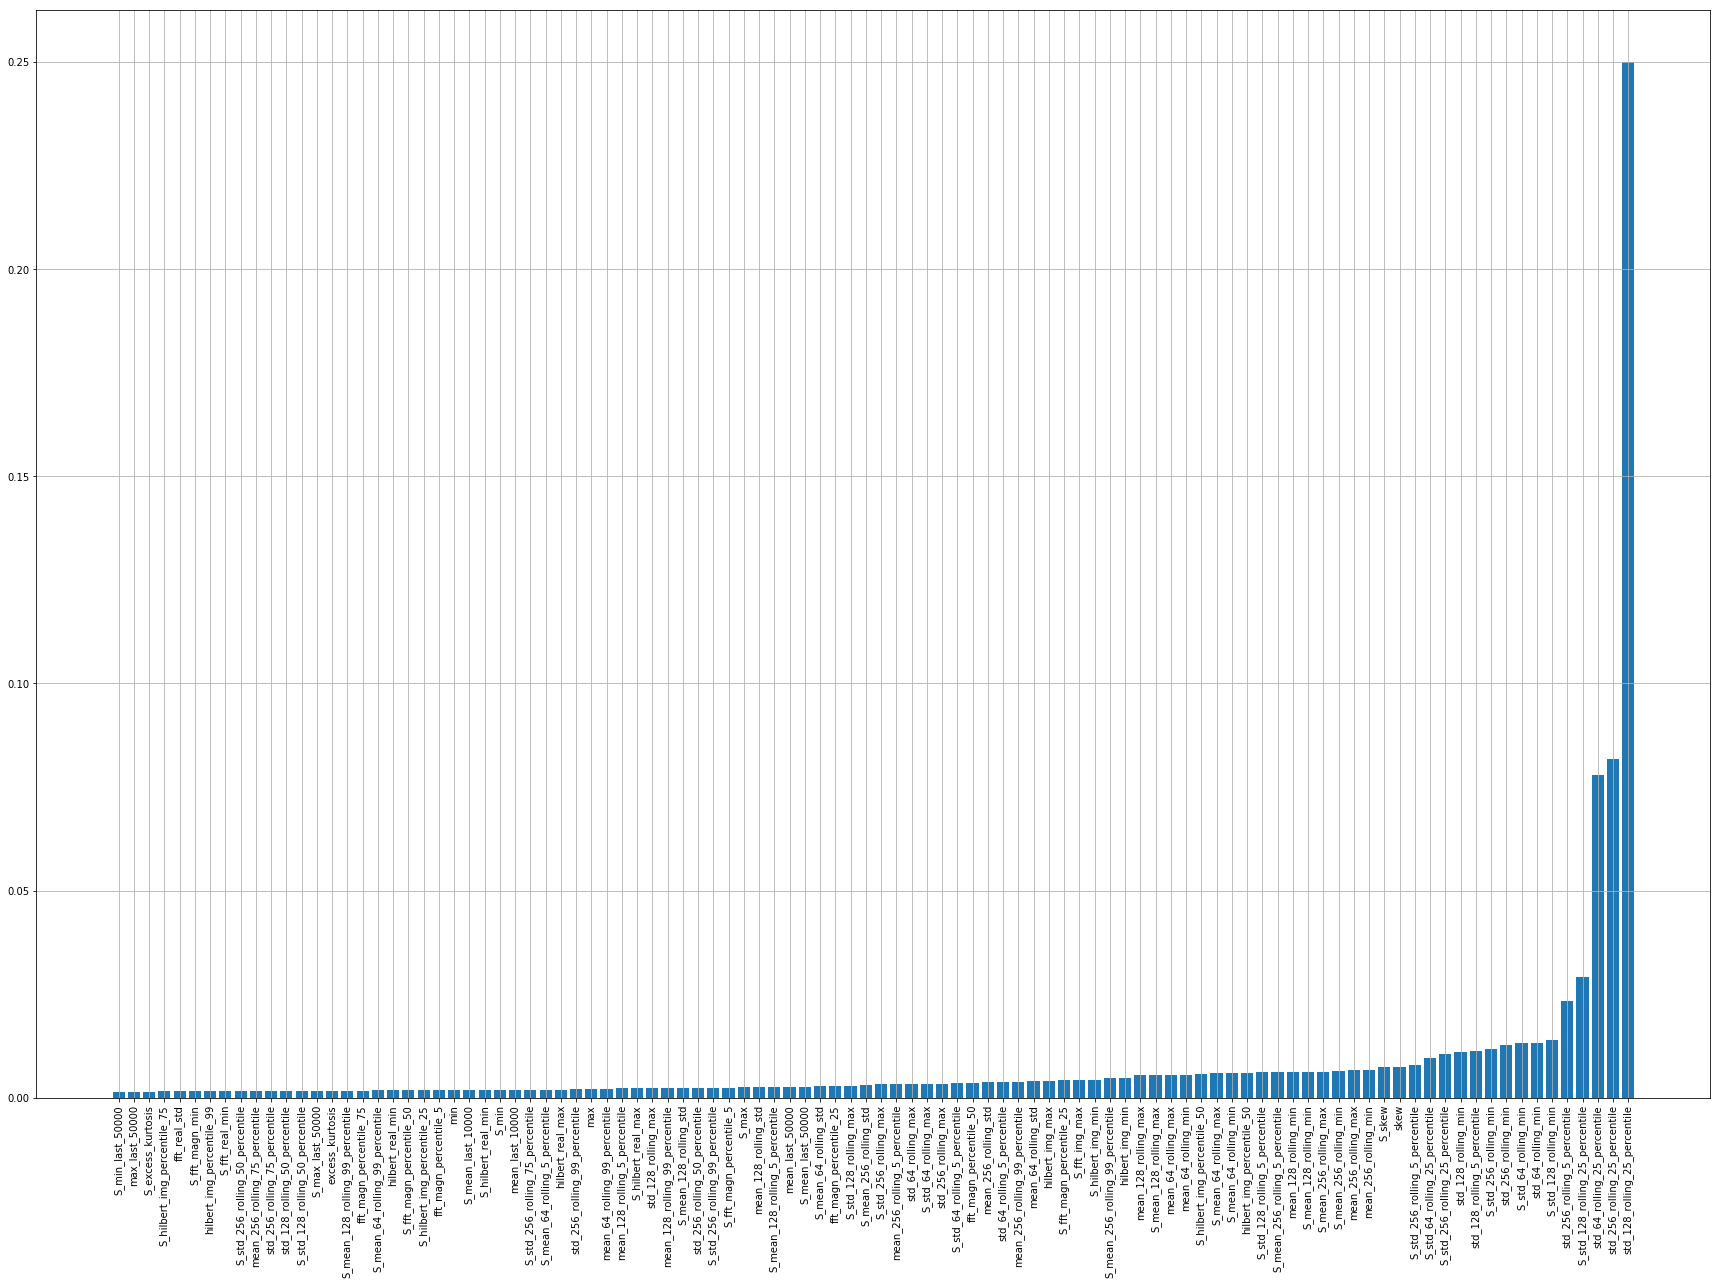

In [21]:
k = np.argsort(rf.feature_importances_)[-100:]
imp = np.sort(rf.feature_importances_)[-100:]
temp_cols = [column_names[i] for i in k]
plt.figure(figsize=(30,20))
plt.bar(temp_cols,imp)
plt.xticks(rotation=90)
plt.grid()
plt.show()

## XGBoost

In [23]:
params = {'max_depth':[1,3,5,7],'n_estimators':[5,10,25,50,100,200]}
xgb = XGBRegressor(n_jobs=-1,random_state=42)
clf = GridSearchCV(xgb,params,verbose=3,cv=5)
clf.fit(train_df,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=1, n_estimators=5 .....................................
[13:14:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ........ max_depth=1, n_estimators=5, score=-0.446, total=   2.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] max_depth=1, n_estimators=5 .....................................
[13:14:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ........ max_depth=1, n_estimators=5, score=-0.464, total=   1.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] max_depth=1, n_estimators=5 .....................................
[13:14:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ........ max_depth=1, n_estimators=5, score=-0.508, total=   1.1s
[CV] max_depth=1, n_estimators=5 .....................................
[13:14:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ........ max_depth=1, n_estimators=5, score=-0.270, total=   1.1s
[CV] max_depth=1, n_estimators=5 .....................................
[13:14:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ........ max_depth=1, n_estimators=5, score=-0.509, total=   1.1s
[CV] max_depth=1, n_estimators=10 ....................................
[13:14:52] 

[13:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ....... max_depth=3, n_estimators=200, score=0.544, total=  36.0s
[CV] max_depth=3, n_estimators=200 ...................................
[13:21:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ....... max_depth=3, n_estimators=200, score=0.617, total=  36.3s
[CV] max_depth=3, n_estimators=200 ...................................
[13:21:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ....... max_depth=3, n_estimators=200, score=0.542, total=  36.1s
[CV] max_depth=3, n_estimators=200 ...................................
[13:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/

[CV] ........ max_depth=7, n_estimators=50, score=0.606, total=  19.8s
[CV] max_depth=7, n_estimators=50 ....................................
[13:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ........ max_depth=7, n_estimators=50, score=0.622, total=  20.1s
[CV] max_depth=7, n_estimators=100 ...................................
[13:36:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ....... max_depth=7, n_estimators=100, score=0.701, total=  39.0s
[CV] max_depth=7, n_estimators=100 ...................................
[13:36:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ....... max_depth=7, n_estimators=100, score=0.754, total=  39.0s
[CV] max_de

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 31.3min finished


[13:46:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7],
                         'n_estimators': [5, 10, 25, 50, 100, 200]},

In [24]:
clf.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [36]:
xgb = XGBRegressor(max_depth=7,n_estimators=200,n_jobs=-1)
xgb.fit(train_df,y_train)
y_train_pred = xgb.predict(train_df)
print('mean absolute error for train is:',mean_absolute_error(y_train,y_train_pred))
with open('xgb.pkl','wb') as f:
    pickle.dump(xgb,f)

[14:05:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mean absolute error for train is: 0.8491438631912508


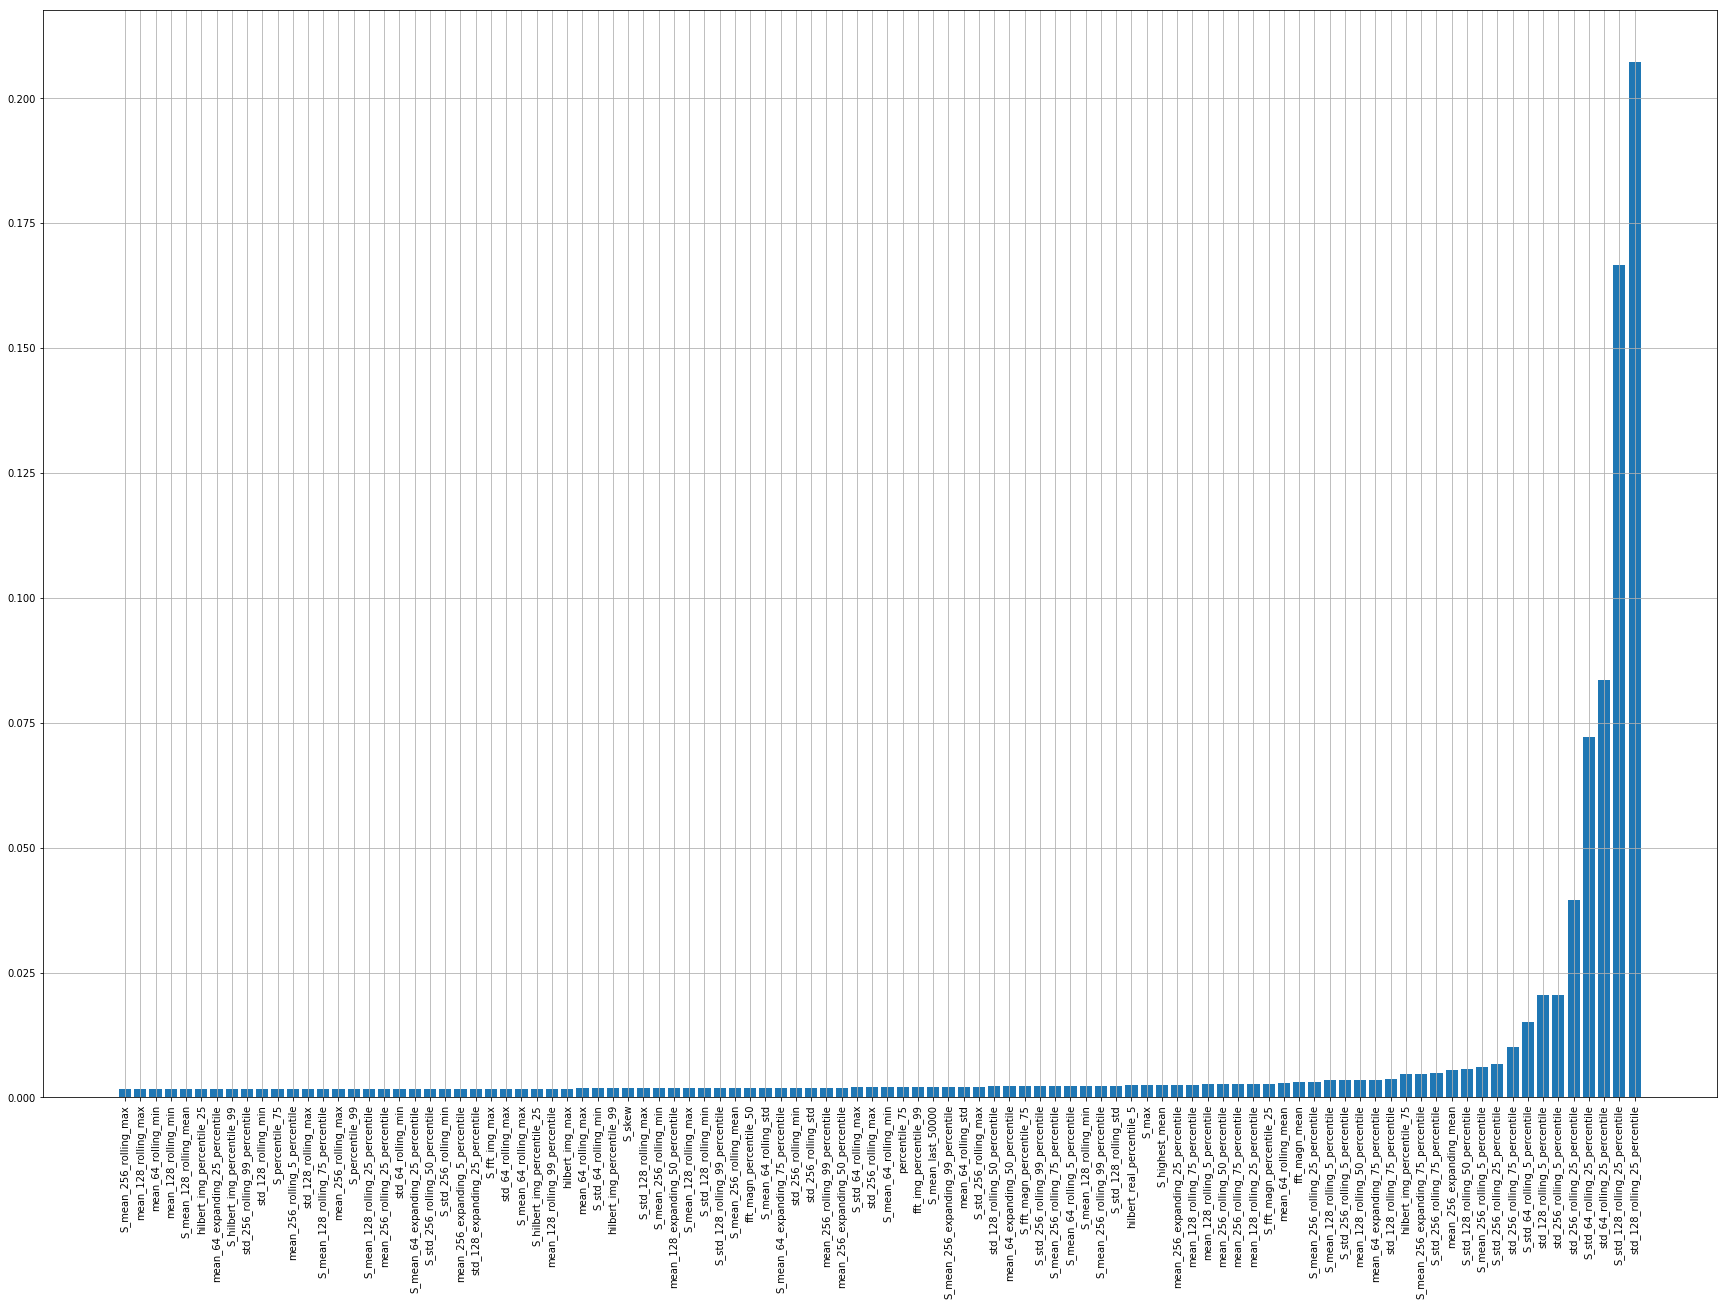

In [26]:
k = np.argsort(xgb.feature_importances_)[-100:]
imp = np.sort(xgb.feature_importances_)[-100:]
temp_cols = [column_names[i] for i in k]
plt.figure(figsize=(30,20))
plt.bar(temp_cols,imp)
plt.xticks(rotation=90)
plt.grid()
plt.show()

## LightGBM

In [28]:
params = {'max_depth':[1,3,5,7],'n_estimators':[5,10,50,100,200]}
lgb = LGBMRegressor(n_jobs=-1,random_state=42)
clf = GridSearchCV(lgb,params,verbose=3,cv=5)
clf.fit(train_df,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.237, total=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.276, total=   1.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.254, total=   1.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.234, total=   1.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ......... max_depth=1, n_estimators=5, score=0.268, total=   1.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ........ max_depth=1, n_estimators=10, score=0.336, total=   1.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ........ max_depth=1, n_estimators=10, score=0.396, total=   1.2s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ........ max_depth=1, n_estimators=10, score=0.360, total=   1.1s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ........ max_depth=1, n_estimators=10, score=0.335, total=   1.0s
[CV] m

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7],
                         'n_estimators': [5, 10, 50, 100, 200]},
             pre_dispatch='2*n_jobs', refit=True, retur

In [29]:
clf.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [30]:
lgb = LGBMRegressor(max_depth=7,n_estimators=200,n_jobs=-1)
lgb.fit(train_df,y_train)
y_train_pred = lgb.predict(train_df)
print('mean absolute error for train is:',mean_absolute_error(y_train,y_train_pred))
with open('lgbm.pkl','wb') as f:
    pickle.dump(lgb,f)

mean absolute error for train is: 1.2210776563290604


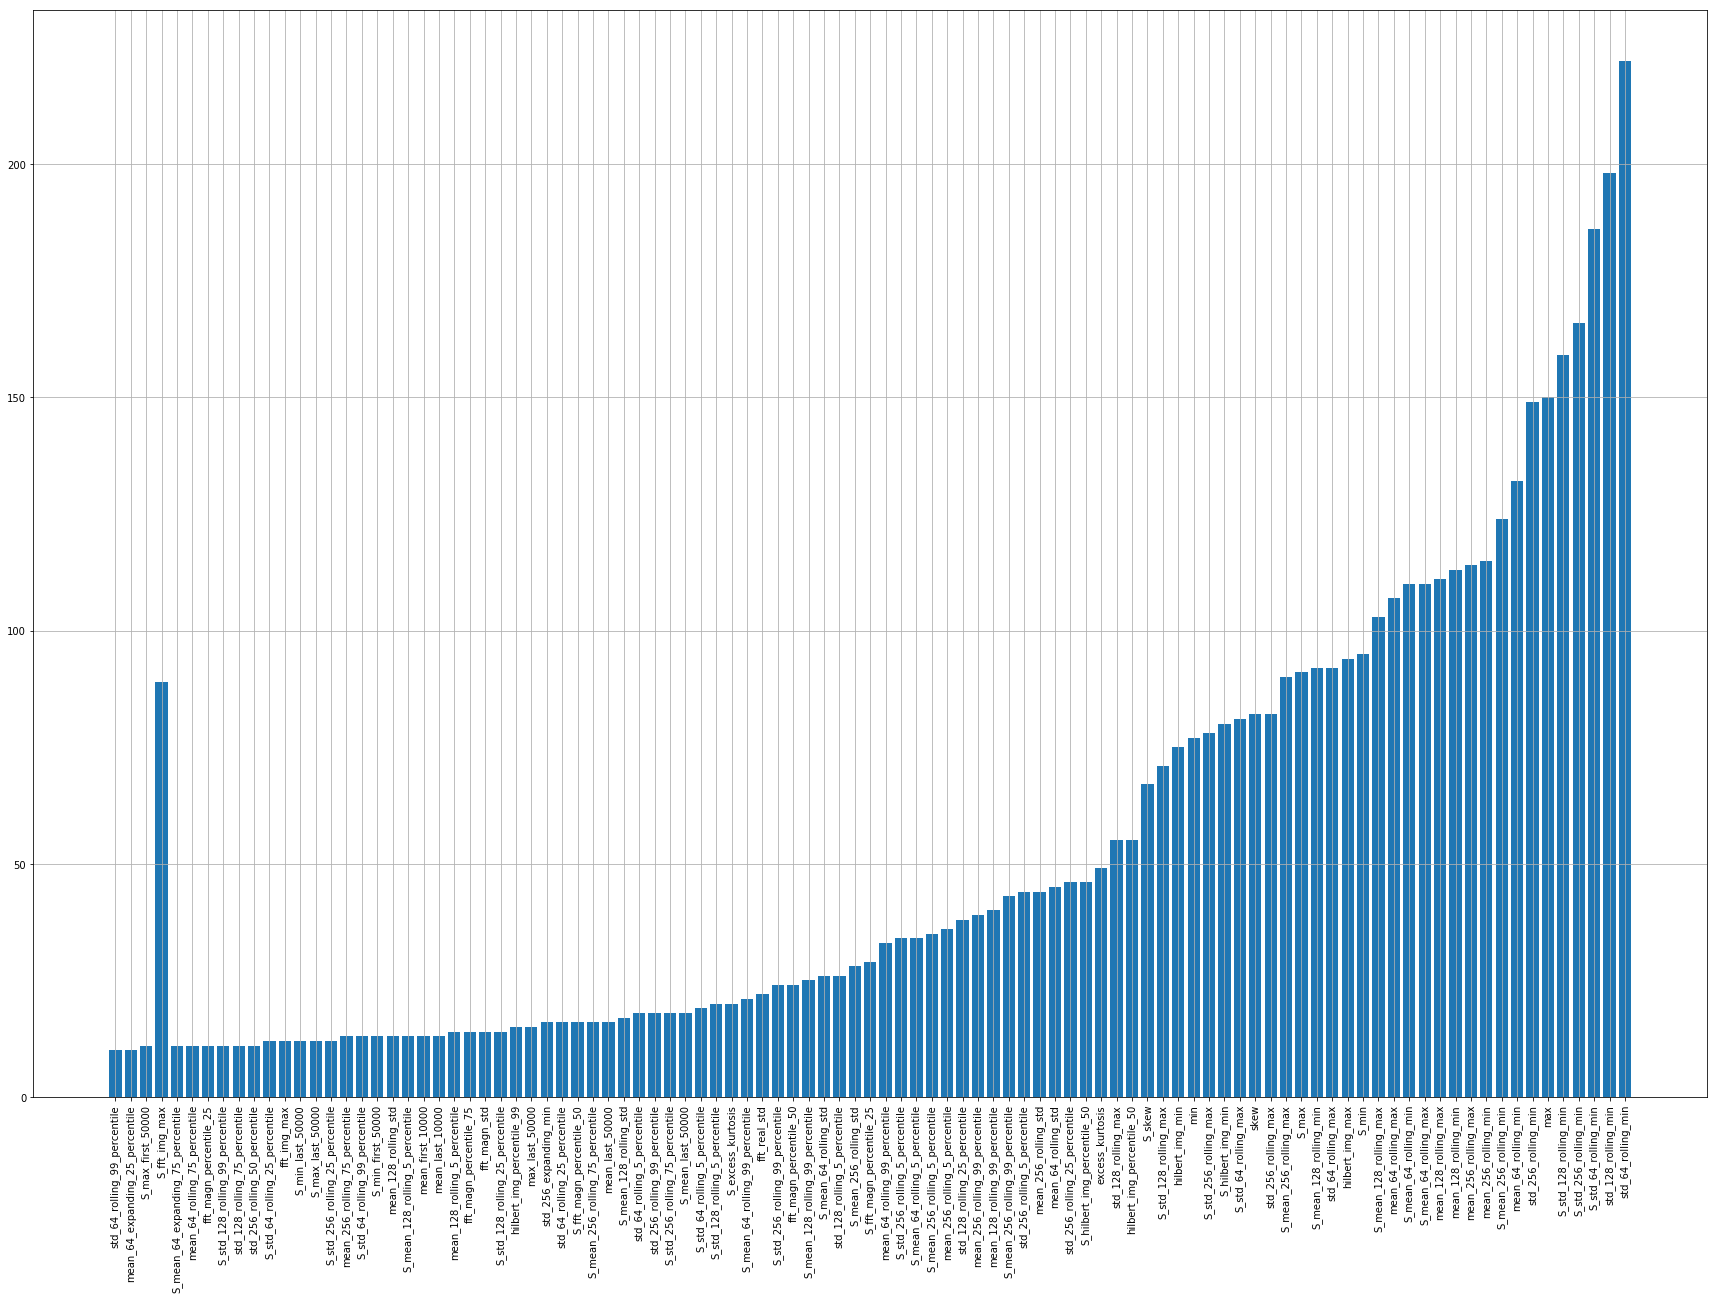

In [34]:
k = np.argsort(lgb.feature_importances_)[-100:]
imp = np.sort(lgb.feature_importances_)[-100:]
temp_cols = [column_names[i] for i in k]
plt.figure(figsize=(30,20))
plt.bar(temp_cols,imp)
plt.xticks(rotation=90)
plt.grid()
plt.show()

## Comparing Models

In [37]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model','MAE']
x.add_row(['Linear Regression',2.051937103440434])
x.add_row(['Random Forest Regressor',0.4034145876015813])
x.add_row(['XGBoost Regressor',0.8491438631912508])
x.add_row(['LGBM Regressor',1.2210776563290604])
x.sortby = 'MAE'
print(x)

+-------------------------+--------------------+
|          Model          |        MAE         |
+-------------------------+--------------------+
| Random Forest Regressor | 0.4034145876015813 |
|    XGBoost Regressor    | 0.8491438631912508 |
|      LGBM Regressor     | 1.2210776563290604 |
|    Linear Regression    | 2.051937103440434  |
+-------------------------+--------------------+


## Prediction on test data and making a submission file

In [54]:
x_test = pd.read_csv('test.csv')
x_test.shape

(2624, 364)

In [55]:
files = os.listdir('test/')
final_files = []
for file in files:
    final_files.append(file[:-4])
submission = pd.DataFrame()
submission['seg_id'] = final_files

In [56]:
with open('rf.pkl','rb') as f:
    regressor = pickle.load(f)
    
test_pred = regressor.predict(x_test)
submission['time_to_failure'] = test_pred

In [57]:
submission.to_csv('submission.csv',index=False)

## Conclusion
- We can see that the model that performs the best is the LightGBM Regressor.
- In the best model, the most important feature seems to be the 'Sharpened_precentile_5'.

# References
- Sneha Sathish's github (https://github.com/SnehaSathishRao/LANL/)
- Andrew Lukyanenko's notebook (https://www.kaggle.com/artgor/seismic-data-eda-and-baseline)
- Heeryon Cho and Sang Min Yoon's paper on Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening.
- https://www.kaggle.com/artgor/even-more-features
- https://www.kaggle.com/vettejeep/masters-final-project-model-lb-1-392